# Task 1: Generate adversarial examples in the context of the zero-knowledge threat model

## Threat model in deep learning: background and definitions
We focus on deep learning systems that are trained in a supervised setting. This modality of deep neural network (DNN) models unseen samples to a predefined set of outputs, using a function obtained from training with labeled data. Here, we use a machine learning classifier, defined by a function $f(\cdot)$, that receives an input $x$ and output a class probability vector $y$ of all possible classes.  

### Adversarial goals  
The adversary of a deep learning system seeks to provide a modified input $x'$, called an adversarial example, that results in an incorrect output classification (JSMA paper). This form of adversarial sample has the goal of generating inputs that are still correctly classified by humans and classifiers other than the targeted DNN. Adversarial attacks can also be distinguished by how they seek to impact the DNN output integrity: a) reduce output confidence classification; b) modify the output classification to any class other the true class; c) generate an $x'$  that forces the output classification into a specific target class; and d) modify an $x$ so that the resulting $x'$ forces the output classification into a specific target class. The first two goals are referred to as *untargeted* attacks, whereas the last two are referred to as *targeted* attacks.

### Defense
A *defense* has the goal of obtaining a correct prediction even when an adversarial example is the input: $argmax(f(x))=argmax(f(x'))=y$. In the Athena framework, the defense mechanism is a combination of several diverse weak defenses. Within the context of this assignment, however, the target of the attacks will be the *undefended model* $f$ that is trained on the original dataset $D$. Additionally, the performance of another state-of-the-art defense called *Projected Gradient Decent Adversarial Training* (PGD-ADT) was compared to the undefended model and to the vanilla Athena ensemble. The PGD-ADT approach is to train networks on both the inputs $x$ and on PGD adversaries (described below).

## Experimental settings

### Description of attacks

We generated adversarial examples using three different attack methods. All three methods are *gradient-based attacks*. In the case of image recognition such as this one, this means that they develop a perturbation vector for the input image by 1) holding constant the model weights and treating the input as variable, and 2) obtaining a gradient correspondent to each pixel. This jointly minimizes the perturbation and maximizes the probability of "fooling" the classifier (i.e., the probability of the input being misclassified).

For each method, we created several variants. These variants were obtained by tuning the attack parameters of each, which are described below.

#### Attack 1: Fast Gradient Sign Method (FGSM; Goodfellow, Shlens, & Szegedy, 2015)
This method processes adversarial examples as follows:

$$ x' = x + \epsilon \cdot sign(\nabla_xJ(x,y)) $$

where $x'$ is the adversarial image, $J$ is the cost (loss) function of the target model $f$, $\nabla_x$ is the gradient with respect to the input $x$ (original image) with corresponding correct output $y$ (original label), and $\epsilon$ is the magnitude of the perturbation (the change made to the pixels).

Note that the $\epsilon$ parameter is a vector multiplier that ensures the perturbation is small - just large enough to provoke misclassification. We chose values of $\epsilon$ in the range of 0.1 to 1 in increments of 0.1 ($\epsilon$ = 0.1, 0.2, ..., 1.0).

#### Attack 2: Jacobian-based Saliency Map Attack (JSMA; Papernot, McDaniel, Jha, Fredrikson, Celik, & Swami, 2016)
This method make changes to the input through the use of the *forward derivative*: the gradient of loss with each class labels with respect to all components of the input. In other words, the forward derivative is the Jacobian of the function learned by the DNN. It is used to build *adversarial saliency maps* to determine which input features (e.g., what parts of the image) should be disturbed to maximize classification error. Note that this can be done by either *increasing* or *decreasing* input features (e.g., pixel intensity).
The formulation of the saliency map where we increase high-saliency pixels $x_{(i)}$ is


$$
S(x_{(i)},c) = \left\{
    \begin{array}\\
        0\, \text{if}\, \frac{\partial f(x)_{(c)}}{\partial x_{(i)}}\, <\, 0\, \text{or}\, \displaystyle\sum_{c'\neq c} \frac{\partial f(x)_{(c')}}{\partial x_{(i)}}\ >\ 0 \\
        -\frac{\partial f(x)_{(c)}}{\partial x_(i)}\ \cdot\ \displaystyle\sum_{c'\neq c} \frac{\partial f(x)_{(c')}}{\partial x_{(i)}}\, \text{otherwise.}
    \end{array}
\right.
$$


This approach differs from the FGSM because it reduces the number of perturbations (i.e, the number of pixels it disturbs). We do not report results for this method because after several runs with extreme parameters, none of the results were meaningfully different.

#### Attack 3: Projected Gradient Descent (PGD; Madry, Makelov, Schmidt, Tsipras, & Vladu, 2019)
This is an iterative approach that gradually increases the magnitude of the perturbation until the input is misclassified. Like other methods, it aims to minimize the following worst case loss function over all possible perturbations:

$$\rho(\theta)=E_{(x,y)\sim D}\, \bigg[ \max\limits_{\delta\, \in\, S}L(\theta, x + \delta,y) \bigg]$$

The FGSM described previously approaches is an attack for an $l_\inf$-bounded adversary and generates adversarial examples as seen above. Another adversarial approach is a multi-step variant, which is the *projected gradient descent* (PGD) on the negative loss function

$$ x^{t+1} = \prod_{x+S}(x^t\ +\ \alpha sign(\nabla_x L(\theta,x,y))) $$

For the PGD, we generated attacks in two ways:
1. Manipulating the size of the perturbation, $\epsilon$, from 0.1 to 1 in increments of 0.1 with fixed maximum iteration of 10.
2. Manipulating the number of maximum iterations from 10 to 30 by increments of 2 (10,12,14,...,30) with a fixed $\epsilon$ of 0.3.

### Description of models implemented in the evaluation (weak defenses)

#### Undefended model (UM in figure captions)
A raw cnn model trained on the clean input images and corresponding true labels.  This model has no defenses implemented to defend against aversarial examples

#### "Baseline" model (BL in figure captions)
A PGD-ADT model that has been trained with a set of AEs not just clean input images.  ADT stands for adversarial training, indicating that this model has been trained with PGD adversarial examples.  By training the model with true labels and input images that are AEs, this model in theory should be better prepared than the UM to recognize future input that have been altered from the clean input.

#### Vanilla athena (Ensemble in figure captions)
This defense combines multiple different models trained with different AE inputs into one "ensemble" model.  It takes the estimated class from these several different models and then returns an output class based based on the collected guess of the individual models.  Like the PGD-ADT, each of these ensembled models was trained using AE inputs and true labels, and by combining models from different types of AEs it should be relatively robust to effectively acount for different types of AE input it encounters going forward.  The specific individual models included in this ensemble are detailed in the configs file Task1/configs/athena-mnist.  Each of these corresponds to a type of AE it is trained with and are various transformations applied to the clean data.


## Evaluation of results: error rate
Results in terms of error rate by attack method are plotted below. The defenses are coded by color: yellow is the undefended model, green is the Athena ensemble of weak defenses, and blue is the baseline defense model, PGD-ADT. 

The top plot shows the performance of each defense against FGSM adversarial attacks. The undefended model starts ($\epsilon$ = .1) with a 25% error rate and reaches the peak error rate of 92% at $\epsilon$ = 0.4. The Athena and PGD-ADT defenses have essentially equal error rates for $\epsilon$ = 0.1 and 0.2; at $\epsilon$ = 0.3, however, Athena has 67% error rate while PGD-DT has an error rate of 21%. At $\epsilon$ = 0.5 and upwards, all defenses are essentially equivalent with error rates around 90%.

The middle plot shows the performance of each defense against PGD attacks with changing attack intensities, similar as the above. The undefended model has error rate of 65% at $\epsilon$ = 0.1 and sharply reaches 99% at $\epsilon$ = 0.2. Athena and PGD-ADT perform more closely in these scenarios, with their largest difference at $\epsilon$ = 0.4: 23%. Athena and PGD-ADT are equivalent again at $\epsilon$ = 0.6, with an error rate of 88%. For stronger attacks ($\epsilon$ = 0.8 and above), Athena is the defense with smallest error rate, and is 7% more accurate than the other methods.

The last plot demonstrates the change in error rate as the number of iterations is manipulated in PGD attacks with $\epsilon$ = 0.3. The minimum error rate for Athena is 29% at 10 iterations and the maximum error rate is 59% at 30 iterations. For PGD-ADT, the minimum error rate is 18% and the maximum is 33%. Note that the minimum difference between the two methods is 11%, at 10 iterations, and the maximum difference is 26%, at 30 iterations.

#### Example FGSM with Epsilon of 0.1 

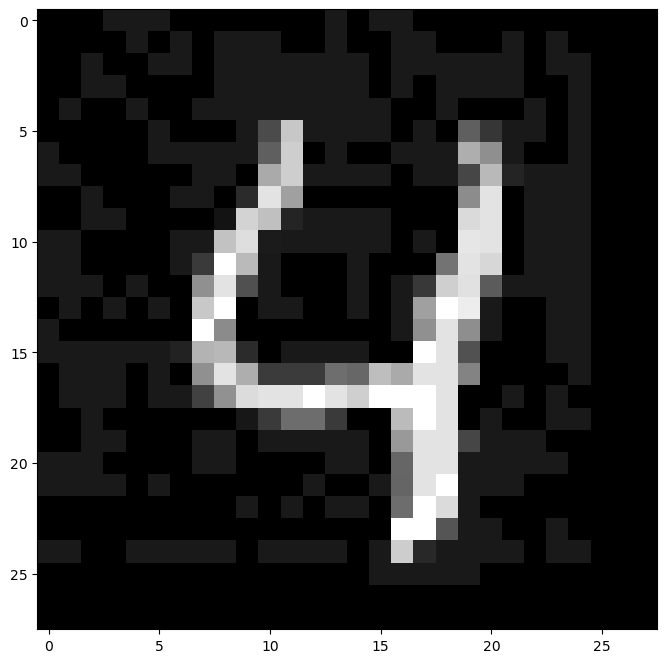

In [18]:
import numpy as np
import matplotlib.pyplot as plt


fgsm = np.load('../Task2/data/fgespof0.1.npy')
fgsmeps1 = fgsm[4,:,:,0]
plt.imshow(fgsmeps1,cmap ='gray')
plt.show()

#### Example FGSM with Epsilon of 0.8 

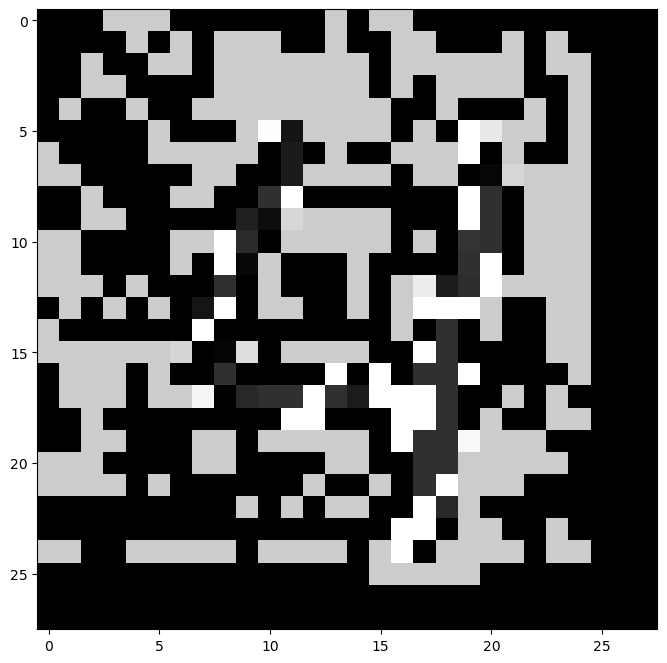

In [19]:
fgsm = np.load('../Task2/data/fgespof0.8.npy')
fgsmeps8 = fgsm[4,:,:,0]
plt.imshow(fgsmeps8,cmap ='gray')
plt.show()

#### Example PGD with Epsilon of 0.1

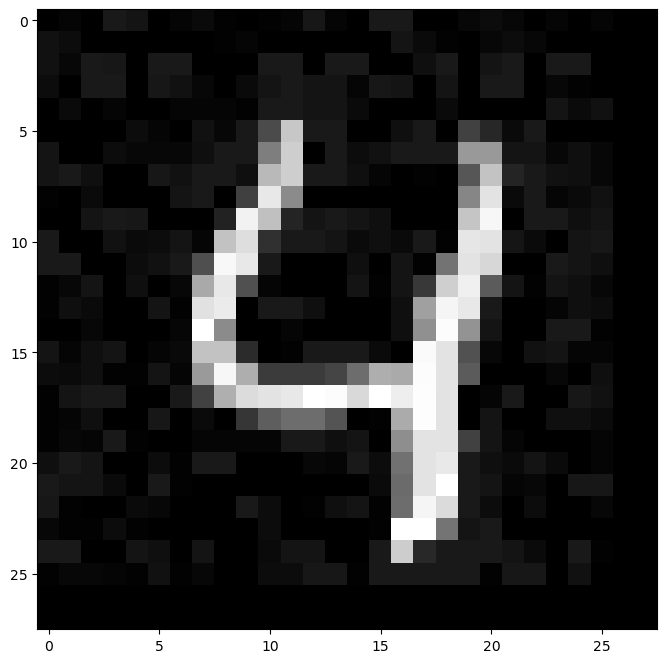

In [20]:
pgd = np.load('../Task2/data/espof0.1.npy')
pgdeps1 = pgd[4,:,:,0]
plt.imshow(pgdeps1,cmap ='gray')
plt.show()

#### Example PGD with Epsilon of 0.8 

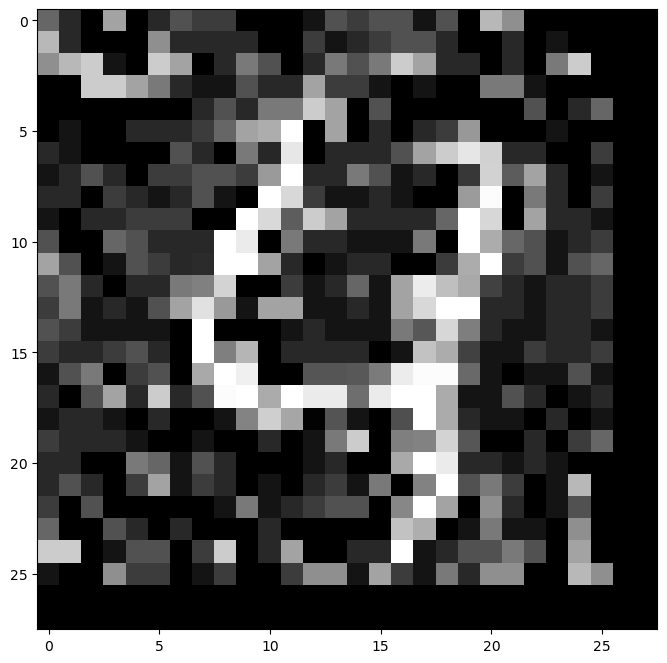

In [21]:
pgd = np.load('../Task2/data/espof0.8.npy')
pgdeps8 = pgd[4,:,:,0]
plt.imshow(pgdeps8,cmap ='gray')
plt.show()

#### Example PGD with Max Iterations se to 12

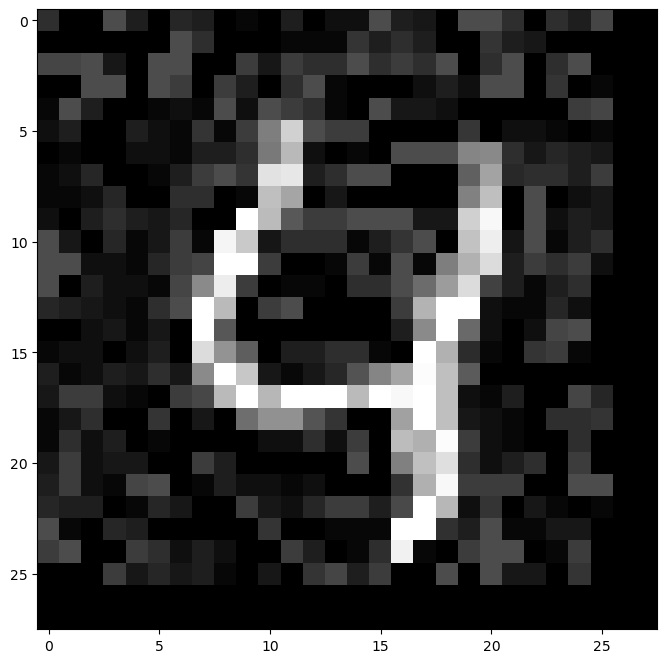

In [22]:
maxiter = np.load('../Task2/data/maxiter12.npy')
maxiter12 = maxiter[4,:,:,0]
plt.imshow(maxiter12,cmap ='gray')
plt.show()

#### Example PGD with Max Iterations se to 30

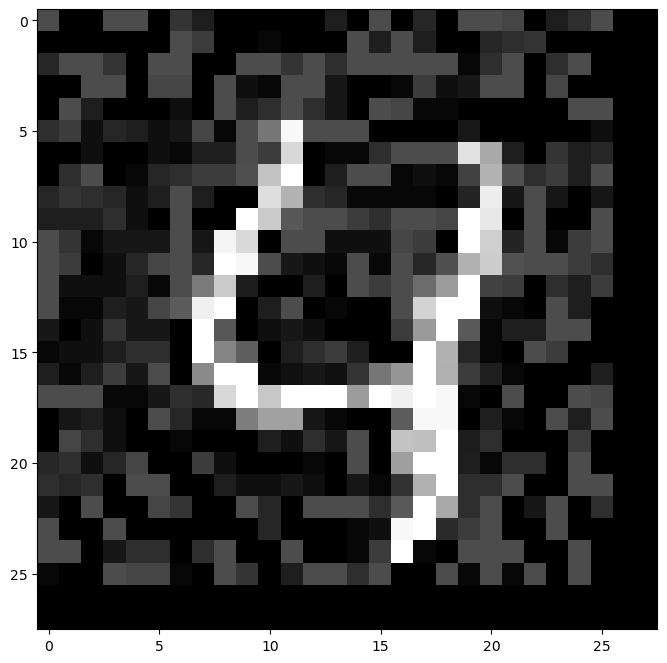

In [23]:
maxiter = np.load('../Task2/data/maxiter30.npy')
maxiter30 = maxiter[4,:,:,0]
plt.imshow(maxiter30,cmap ='gray')
plt.show()

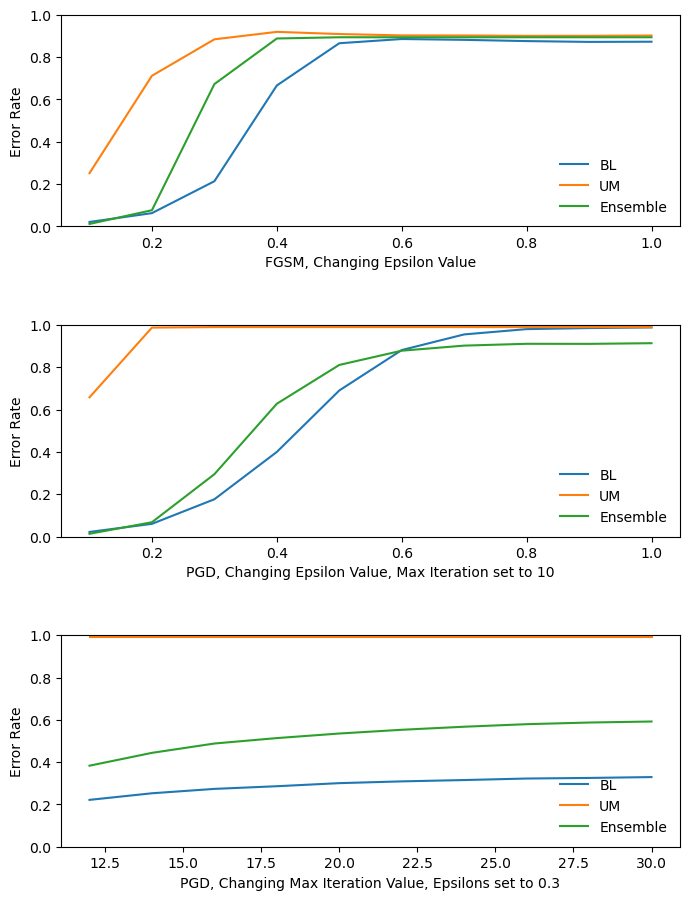

In [24]:
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings('ignore')

path = 'results/dataOut_task1.csv'

df = pd.read_csv(path, header = None, index_col = None, parse_dates =  True)
df.columns = ['num','ae','UM','BL','Ensemble']
df = df.drop([0])
#eps fgsm['nes'].iloc[x]= "epsof"


fgsm = df.iloc[21::]
i = 0
temp = []
for x in fgsm['ae']:
    temp.append(float(x.split('f')[2].replace(',',"")))
    i+=0
fgsm['nes']=temp

pgdesp = df.iloc[0:10] 

i = 0
temp = []
for x in pgdesp['ae']:
    temp.append(float(x.split('f')[1].replace(',',"")))
    i+=0
pgdesp['nes']=temp

pgditer =df.iloc[11:21] 

i = 0
temp = []
for x in pgditer['ae']:
    temp.append(float(x.split('r')[1].replace(',',"")))
    i+=0
pgditer['nes']=temp


plt.rcParams['figure.figsize'] = [8, 10]
plt.rcParams['figure.dpi'] = 100
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig.tight_layout(pad=5.0)

ax1.plot(fgsm['nes'],np.array(fgsm['BL'],dtype=float),label='BL')
ax1.plot(fgsm['nes'],np.array(fgsm['UM'],dtype=float),label='UM')
ax1.plot(fgsm['nes'],np.array(fgsm['Ensemble'],dtype=float),label='Ensemble') 
ax1.set_ylim(0,1)
ax1.set_ylabel("Error Rate")
ax1.set_xlabel('FGSM, Changing Epsilon Value')
ax1.legend(loc='lower right', frameon=False);


ax2.plot(pgdesp['nes'],np.array(pgdesp['BL'],dtype=float),label='BL')
ax2.plot(pgdesp['nes'],np.array(pgdesp['UM'],dtype=float),label='UM')
ax2.plot(pgdesp['nes'],np.array(pgdesp['Ensemble'],dtype=float),label='Ensemble') 
ax2.set_ylim(0,1)
ax2.set_ylabel('Error Rate')
ax2.set_xlabel('PGD, Changing Epsilon Value, Max Iteration set to 10')
ax2.legend(loc='lower right', frameon=False);

ax3.plot(pgditer['nes'],np.array(pgditer['BL'],dtype=float),label='BL')
ax3.plot(pgditer['nes'],np.array(pgditer['UM'],dtype=float),label='UM')
ax3.plot(pgditer['nes'],np.array(pgditer['Ensemble'],dtype=float),label='Ensemble') 
ax3.set_ylim(0,1)
ax3.set_ylabel('Error Rate')
ax3.set_xlabel('PGD, Changing Max Iteration Value, Epsilons set to 0.3')
ax3.legend(loc='lower right', frameon=False);

#plt.xlim(dates.iloc[1],dates.iloc[-1])
#ax1.set_ylim(0,1)
#ax1.axhline(color='r')
#ax1.set_title("Correct Guess")
#ax1.set_ylabel('Velocity (m/yr)')

## Discussion/ Observations

-For both PGD and FGSM epsilon had a significant effect on the model error rates and visual differences in the AE images themselves.  This makes sense: as the controlling paramter is increased the effect of the AE increases too.

-We expected the ensemble to have a lower error rate overall than the PGD-ADT because it incorporates a variety of AEs in its defense.  However, that wasn't the case with our data.  We did use PGD as an AE and so the PGD-ADT may be optimized for that case but we also see PGD-ADT having a better accuracy than ensemble for much of the FGSM cases as well (although that switches at high epsilon values)

-Changes to max iterations on PGD had little effect on both the error rate and visual changes to the AE images.  This suggests that it is less of a controlling factor than epsilon.

## Contributions

We worked together to create a plan on how to complete the assignment. All team members did portions of all aspects of the assignment (planning, coding, and writing). Isaac K is the most proficient in python so he would help the most in cleaning Jacob and Raul's codes as well as helping through the hard parts of coding. Raul wrote the initial draft of the report with Isaac and Jacob collaborating to proofread and fill in theoretical descriptions of what exacty was executed and observed. Raul and Jacob added figures.

We met up in Isaacs lab and all 3 team members used Isaac's lab computer to run our codes because it was much faster than Jacob or Raul's machines. This also helped with git merging issues, but makes the git contibutions look skewed if analyzing that aspect (we also only got more effective with git towards the end and so had to reset or repository multiple times). 

## References
Goodfellow, I.J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. CoRR, abs/1412.6572.

Madry, A., Makelov, A., Schmidt, L., Tsipras, D., & Vladu, A. (2018). Towards Deep Learning Models Resistant to Adversarial Attacks. ArXiv, abs/1706.06083.

Papernot, N., McDaniel, P., Jha, S., Fredrikson, M., Celik, Z.Y., & Swami, A. (2016). The Limitations of Deep Learning in Adversarial Settings. 2016 IEEE European Symposium on Security and Privacy (EuroS&P), 372-387.